# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats as stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error, precision_score, recall_score,\
confusion_matrix, precision_recall_fscore_support, classification_report,\
plot_roc_curve, roc_auc_score

import xgboost

import random
random = 42

# Data

In [2]:
# read the prepared data from our saved csv file from EDA
# this will function as our baseline X
df = pd.read_csv('data/modeling_data.csv', index_col=[0])

# pop the 'target' feature off for our y
y = df.pop('target')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   basin                  59400 non-null  object 
 1   region                 59400 non-null  object 
 2   public_meeting         59400 non-null  bool   
 3   scheme_management      59400 non-null  object 
 4   permit                 59400 non-null  bool   
 5   extraction_type_class  59400 non-null  object 
 6   payment                59400 non-null  object 
 7   quality_group          59400 non-null  object 
 8   quantity               59400 non-null  object 
 9   source_type            59400 non-null  object 
 10  waterpoint_type        59400 non-null  object 
 11  amount_tsh             59400 non-null  float64
 12  gps_height             59400 non-null  float64
 13  longitude              59400 non-null  float64
 14  latitude               59400 non-null  float64
 15  po

In [3]:
# encode the boolean features as numeric
df['public_meeting'] = df.public_meeting.astype('int')
df['permit'] = df.permit.astype('int')

# separate the numerical data
numerical_data = df.select_dtypes(include=[np.number]).copy()

# we are dropping 3 numerical columns due to engineering:
#    amount_tsh (now encoded as 'positive_tsh')
#    population (now encoded as 'pop_encoded')
#    construction_year (now encoded as 'const_year_encoded')
# we are also dropping the 'age' feature we engineered because we decided
# to use the other engineered feature 'const_year_encoded'
numerical_data.drop(['amount_tsh', 'population', 'construction_year', 'age'],
                   axis=1, inplace=True)

# separate the categorical data
categorical_data = df.select_dtypes(include=object).copy()

# set up list of column names to use as prefixes in one hot encoder
p = list(categorical_data.columns)

# encode the categoricals using the column name list as the prefix, drop first
cat_encoded = pd.get_dummies(categorical_data, prefix=p, drop_first=True)

# create a dataframe with unencoded categorical data
raw_model_df = pd.concat([numerical_data, categorical_data], axis=1)

# create a dataframe with encoded categorical data
encoded_model_df = pd.concat([numerical_data, cat_encoded], axis=1)

## Checking correlation

In [4]:
corr_df = pd.concat([encoded_model_df, y], axis=1)
corr_matrix = corr_df.corr()
corr_matrix['target'].sort_values(ascending=False)

target                                         1.000000
quantity_enough                                0.258402
positive_tsh                                   0.224277
waterpoint_type_communal standpipe             0.165314
region_Iringa                                  0.140968
                                                 ...   
waterpoint_type_communal standpipe multiple   -0.114094
const_year_encoded_70s                        -0.131614
quality_group_unknown                         -0.163276
extraction_type_class_other                   -0.295936
waterpoint_type_other                         -0.310295
Name: target, Length: 84, dtype: float64

We do not have any features that correlate strongly with the target, but with so many features that is kind of expected.

## Train/test split and scaling

In [5]:
X_train, X_test, y_train, y_test = train_test_split(encoded_model_df, y,
                                                    test_size=0.25,
                                                    random_state=random)

In [6]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_test_scaled = ss.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Helper Functions

In [7]:
def model_report(model, X_train=X_train_scaled, y_train=y_train,
                X_test=X_test_scaled, y_test=y_test):
    """
    This helper function will allow us to quickly evaluate models that we
    create by reporting the classification report and displaying a confusion
    matrix
    
    Input(s)
    - the model to report on
    - the X_train (default to X_train_scaled)
    - the y_train (default to y_train)
    - the X_test (default to X_test_scaled)
    - the y_test (default to y_test)
    
    
    
    """
    # create the y_pred 
    y_pred = model.predict(X_test)
    
    # generate the confusion matrix
    cmatrix = confusion_matrix(y_test, y_pred)
    # convert into dataframe
    cmatrix_df = pd.DataFrame(cmatrix,
                             columns=['Predicted Non-functional',
                                     'Predicted Needs Repair',
                                     'Predicted Functional'],
                             index=['Actual Non-functional',
                                   'Actual Needs Repair',
                                   'Actual Functional'])
    
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10,
                               n_jobs=1)
    print(f"Cross-validation score: {np.median(cv_score)}")
    print(f"Test data score: {model.score(X_test, y_test)}")
    print("------------------------------------------------------")
    
    # print the classification report
    print(classification_report(y_test, y_pred,
                                target_names=['Non functional',
                                              'Needs repair','Functional']))
    # show report as heatmap   
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(data=cmatrix_df, annot=True, cmap='Blues', fmt='g')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)

# Baseline: DummyClassifier

Using a DummyClassifier as our baseline model to compare other models to. We will use the default strategy parameter of 'prior', where the predict method will return the most frequent target label and the predict_proba will return the distribution of the target.

In [8]:
dummy_model = DummyClassifier()

dummy_model.fit(X_train_scaled, y_train)

dummy_model.score(X_train_scaled, y_train)

0.542334455667789

In [9]:
dummy_model.score(X_test_scaled, y_test)

0.5453198653198653

In [10]:
dummy_model.predict_proba(X_test_scaled)[0]

array([0.38487093, 0.07279461, 0.54233446])

So a model guessing that every well is functional would be correct about 54% of the time, which we expected from our analysis of the target distribution during EDA.

# KNearestNeighbors

We are starting with KNearestNeighbors to see how it performs compared to our baseline.

In [11]:
knn_model_baseline = KNeighborsClassifier()
knn_model_baseline.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Cross-validation score: 0.7575757575757576
Test data score: 0.7579124579124579
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.76      0.74      0.75      5678
  Needs repair       0.45      0.32      0.38      1074
    Functional       0.78      0.83      0.81      8098

      accuracy                           0.76     14850
     macro avg       0.66      0.63      0.64     14850
  weighted avg       0.75      0.76      0.75     14850



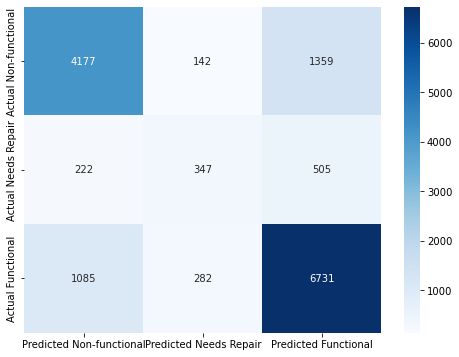

In [12]:
model_report(knn_model_baseline)

## GridSearch

In [13]:
knn_grid = {
    'n_neighbors': [3, 5, 7],
    'metric' : ['minkowski', 'manhattan'],
    'weights': ['uniform', 'distance']
}

In [14]:
knn_gs = GridSearchCV(estimator=knn_model_baseline, param_grid=knn_grid,
                      cv=5, n_jobs=1)

This cell takes about 26 minutes to run

In [15]:
# knn_gs.fit(X_train_scaled, y_train)

In [16]:
# knn_gs.best_params_

Grid Search for KNN produced the following values for hyperparameters:
- metric: 'manhattan'
- n_neighbors: 5
- weights: 'distance'

## KNN v2 - hyperparameter optimization

In [17]:
knn_model_v2 = KNeighborsClassifier(metric='manhattan',
                                   n_neighbors=5,
                                   weights='distance')

knn_model_v2.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', weights='distance')

Cross-validation score: 0.7700336700336701
Test data score: 0.7683501683501683
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.79      0.74      0.77      5678
  Needs repair       0.44      0.38      0.41      1074
    Functional       0.79      0.84      0.81      8098

      accuracy                           0.77     14850
     macro avg       0.67      0.65      0.66     14850
  weighted avg       0.76      0.77      0.77     14850



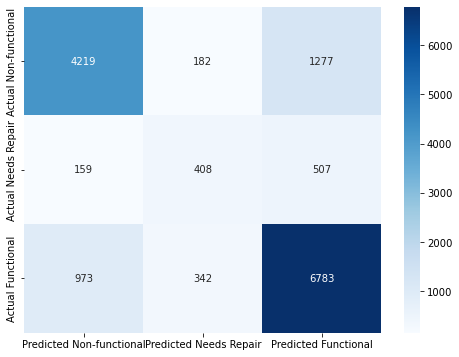

In [18]:
model_report(knn_model_v2)

Slight increase (1.42%) in model performance with optimized parameters, at a major cost for speed (~320% slower). Lets look at some other models.

# RandomForest

In [19]:
rf_model_baseline = RandomForestClassifier(random_state=random)
rf_model_baseline.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Cross-validation score: 0.7898989898989899
Test data score: 0.7863299663299663
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.81      0.77      0.79      5678
  Needs repair       0.48      0.36      0.41      1074
    Functional       0.80      0.86      0.83      8098

      accuracy                           0.79     14850
     macro avg       0.70      0.66      0.68     14850
  weighted avg       0.78      0.79      0.78     14850



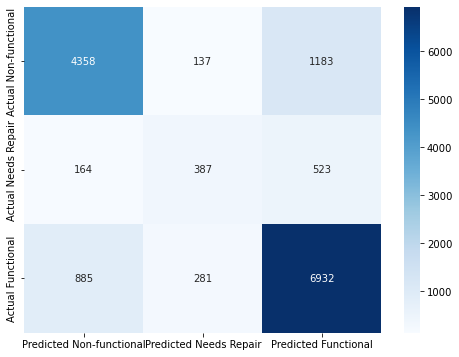

In [20]:
model_report(rf_model_baseline)

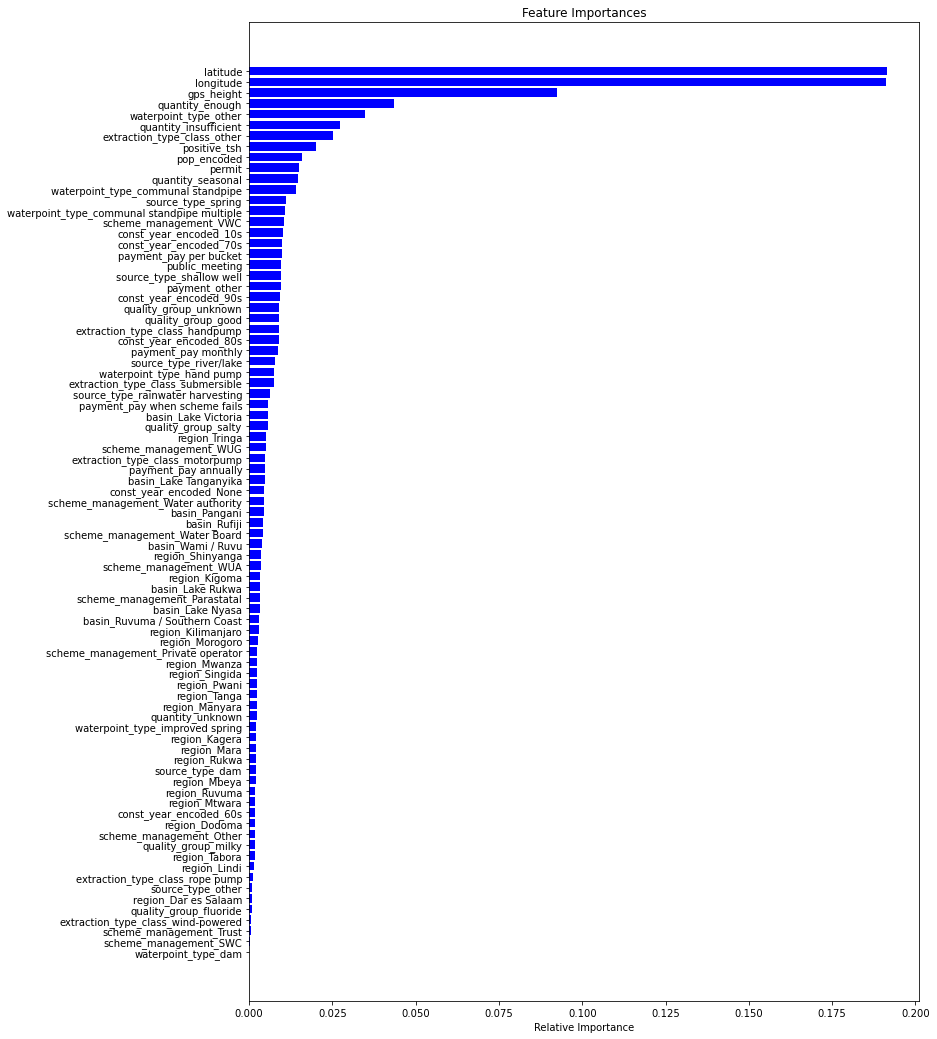

In [21]:
importances = rf_model_baseline.feature_importances_
indicies = np.argsort(importances)
features = X_train_scaled.columns

plt.subplots(figsize=(12, 18))
plt.title('Feature Importances')
plt.barh(range(len(indicies)), importances[indicies], color='b', align='center')
plt.yticks(range(len(indicies)), [features[i] for i in indicies])
plt.xlabel('Relative Importance')
plt.show()

In [22]:
# import shap
# rf_baseline_shap = shap.TreeExplainer(rf_model_baseline).shap_values(X_train_scaled)
# shap.summary_plot(shap_values, X_train_scaled, plot_type='bar')

## GridSearch

In [23]:
rf_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,6,7],
    'criterion' :['gini', 'entropy']
}

In [24]:
rf_grid_search = GridSearchCV(estimator=rf_model_baseline,
                              param_grid=rf_grid, cv=5, n_jobs=1)

This takes about 22 minutes (running on 4 cores)

In [25]:
# rf_grid_search.fit(X_train_scaled, y_train)

In [26]:
# rf_grid_search.best_params_

Best Parameters after GridSearch:
- 'criterion': 'gini'
- 'max_depth': 7
- 'max_features': 'auto'
- 'n_estimators': 200

## RandomForest v2 - hyperparameter optimization

In [27]:
rf_model_v2 = RandomForestClassifier(criterion='gini',
                                    max_depth=7,
                                    max_features='auto',
                                    n_estimators=200)
rf_model_v2.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=7, n_estimators=200)

Cross-validation score: 0.7123456790123457
Test data score: 0.7115151515151515
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.83      0.51      0.63      5678
  Needs repair       0.63      0.03      0.06      1074
    Functional       0.67      0.94      0.79      8098

      accuracy                           0.71     14850
     macro avg       0.71      0.50      0.49     14850
  weighted avg       0.73      0.71      0.68     14850



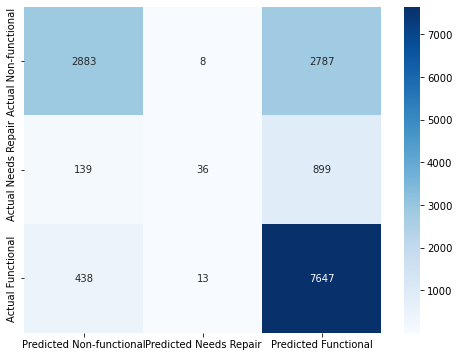

In [28]:
model_report(rf_model_v2)

It looks like hyperparameter optimization actually makes our model perform worse because it further neglects the 'Needs repair' class. Lets try to account for the class imbalance in our data using class weights in the next model

## RandomForest v3 - balanced class weights

In [29]:
rf_model_v3 = RandomForestClassifier(class_weight='balanced',
                                     random_state=random)
rf_model_v3.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Cross-validation score: 0.7910213243546577
Test data score: 0.7866666666666666
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.81      0.77      0.79      5678
  Needs repair       0.48      0.35      0.40      1074
    Functional       0.80      0.86      0.83      8098

      accuracy                           0.79     14850
     macro avg       0.70      0.66      0.67     14850
  weighted avg       0.78      0.79      0.78     14850



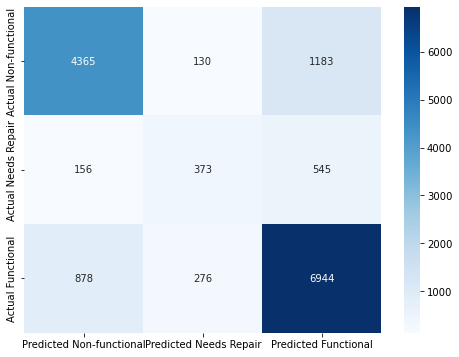

In [30]:
model_report(rf_model_v3)

Balanced weights do improve the baseline model slightly, lets try balanced subsample weights, this may help because our 'Needs repair' class is so small comparatively.

## RandomForest v4 - balanced subsample weights

In [31]:
rf_model_v4 = RandomForestClassifier(class_weight='balanced_subsample', 
                                     random_state=random)
rf_model_v4.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

Cross-validation score: 0.790347923681257
Test data score: 0.7867340067340067
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.81      0.77      0.79      5678
  Needs repair       0.48      0.35      0.40      1074
    Functional       0.80      0.86      0.83      8098

      accuracy                           0.79     14850
     macro avg       0.70      0.66      0.67     14850
  weighted avg       0.78      0.79      0.78     14850



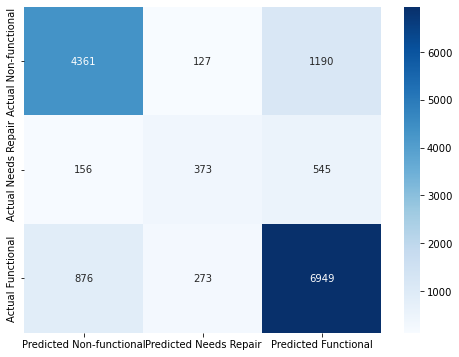

In [32]:
model_report(rf_model_v4)

## RandomForest v5 - labelencoding

We had read that maybe the model could improve with labelencoding the categorical data rather than onehotencoding. This experiment did not result in any model improvement. It's commented out because we do not want to reassign our train/test split variables, but we wanted to keep the code available just in case.

In [33]:
# le = LabelEncoder()

# le_cats = categorical_data.apply(le.fit_transform)
# le_df = pd.concat([numerical_data, le_cats], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(le_df, y, test_size=0.25,
#                                                    random_state=random)

# rf_model_v5 = RandomForestClassifier(class_weight='balanced',
#                                      random_state=random)

# rf_model_v5.fit(X_train, y_train)

# cross_val_score(rf_model_v5, X_train, y_train, cv=5)

# XGBoost

In [34]:
xgb_model_baseline = xgboost.XGBClassifier(random_state=random,
                                           eval_metric='mlogloss',
                                           use_label_encoder=False)
xgb_model_baseline.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

Cross-validation score: 0.788327721661055
Test data score: 0.7851178451178451
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.83      0.72      0.77      5678
  Needs repair       0.62      0.22      0.32      1074
    Functional       0.77      0.91      0.83      8098

      accuracy                           0.79     14850
     macro avg       0.74      0.61      0.64     14850
  weighted avg       0.78      0.79      0.77     14850



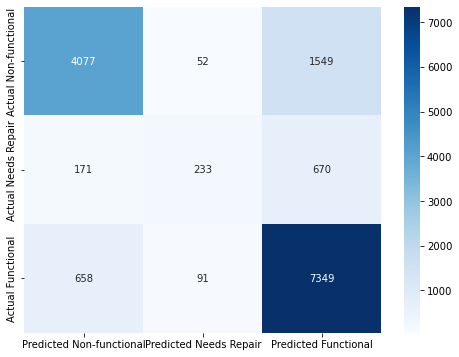

In [35]:
model_report(xgb_model_baseline)

## GridSearch

In [36]:
xgb_grid = {
    'subsample': [0.6, 0.8],
    'gamma': [0.5, 1, 1.5],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10]
}

In [37]:
xgb_grid_search = GridSearchCV(estimator=xgb_model_baseline,
                               param_grid=xgb_grid, cv=5, n_jobs=1)

This grid search takes about 50 minutes running on 4 cores.

In [38]:
# xgb_grid_search.fit(X_train_scaled, y_train)

In [39]:
# xgb_grid_search.best_params_

Grid Search for XGBoost produced the following values for hyperparameters:

- gamma: 0.5
- max_depth: 5
- min_child_weight: 1
- subsample: 0.6

## XGBoost v2 - hyperparameter optimization

In [40]:
xgb_model_v2 = xgboost.XGBClassifier(random_state=random,
                                     use_label_encoder=False, gamma=0.5,
                                    max_depth=5, min_child_weight=1,
                                    subsample=0.6, eval_metric='mlogloss')
xgb_model_v2.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

Cross-validation score: 0.7828282828282829
Test data score: 0.7795959595959596
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.82      0.71      0.76      5678
  Needs repair       0.61      0.21      0.31      1074
    Functional       0.76      0.90      0.83      8098

      accuracy                           0.78     14850
     macro avg       0.73      0.61      0.63     14850
  weighted avg       0.78      0.78      0.77     14850



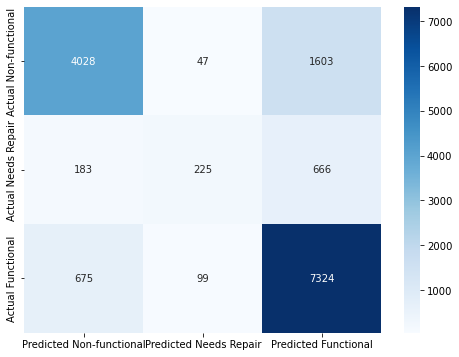

In [41]:
model_report(xgb_model_v2)

## XGBoost v3 - weight scaling

In [42]:
# set up class weights for y_train
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train)
classes_weights

# create model
xgb_model_v3 = xgboost.XGBClassifier(random_state=random,
                                     use_label_encoder=False, gamma=1.5,
                                    max_depth=5, min_child_weight=1,
                                    subsample=0.8, eval_metric='mlogloss')

# fit to training data
xgb_model_v3.fit(X_train_scaled, y_train, sample_weight=classes_weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=1.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

Cross-validation score: 0.780246913580247
Test data score: 0.7097643097643098
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.82      0.72      0.76      5678
  Needs repair       0.25      0.69      0.37      1074
    Functional       0.82      0.71      0.76      8098

      accuracy                           0.71     14850
     macro avg       0.63      0.70      0.63     14850
  weighted avg       0.78      0.71      0.73     14850



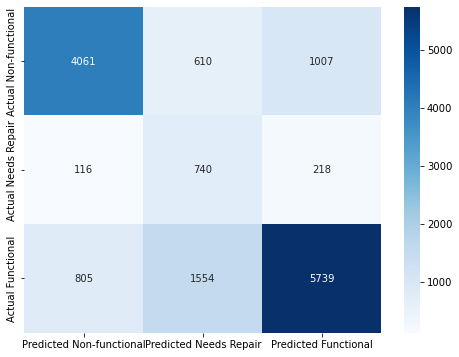

In [43]:
model_report(xgb_model_v3)

# Model Comparison

Of the models created, rf_model_v3 and xgb_model_v3 seem to be contending for best model

Cross-validation score: 0.7910213243546577
Test data score: 0.7866666666666666
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.81      0.77      0.79      5678
  Needs repair       0.48      0.35      0.40      1074
    Functional       0.80      0.86      0.83      8098

      accuracy                           0.79     14850
     macro avg       0.70      0.66      0.67     14850
  weighted avg       0.78      0.79      0.78     14850



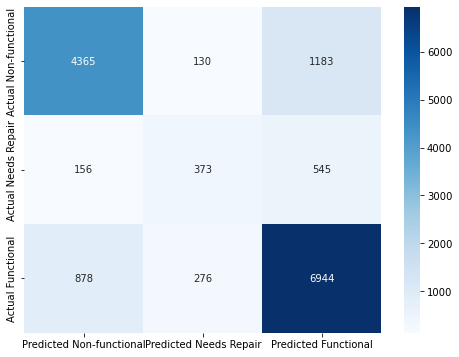

In [44]:
model_report(rf_model_v3)

Cross-validation score: 0.780246913580247
Test data score: 0.7097643097643098
------------------------------------------------------
                precision    recall  f1-score   support

Non functional       0.82      0.72      0.76      5678
  Needs repair       0.25      0.69      0.37      1074
    Functional       0.82      0.71      0.76      8098

      accuracy                           0.71     14850
     macro avg       0.63      0.70      0.63     14850
  weighted avg       0.78      0.71      0.73     14850



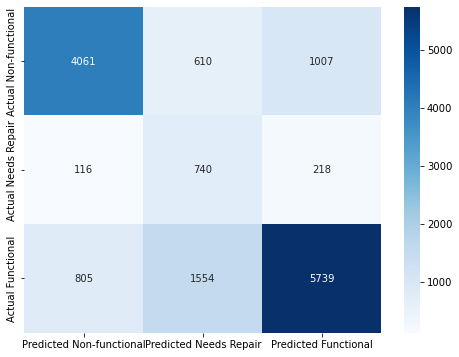

In [45]:
model_report(xgb_model_v3)

Though the overall accuracy of the xgb model is lower, the recall score for 'needs repair' wells is much higher at 0.70. If we remember that our stakeholder wants to focus on wells that need repair, the xgb_model seems to be more attractive. 

The precision for functional and non-functional are about the same in both models. With the xgb_model, we have fewer errors made of wells that were predicted functional but were not. Most of our errors shifted to the predicted 'needs repair' category.

We see the correctly predicted wells needing repair almost doubles with the xgb model; the non-functional wells predicted as needing repair increases by a factor of four though. 
 
At this point we are going to go with the xgb_model_v3 model to model the true test data. The overall accuracy is lower, but the recall on wells needing repair is significantly higher, serving the purposes of our stakeholder.

# Prepare test data

We need to prepare the test data in the same way we processed the training data in our other notebook.

In [46]:
test_data = pd.read_csv('data/test_data.csv')

# the drop list of features we did not use in modeling
drop_list = ['id',
             'num_private',
             'date_recorded',
             'funder',
             'installer',
             'wpt_name',
             'subvillage',
             'lga',
             'ward',
             'recorded_by',
             'scheme_name',
             'extraction_type',
             'extraction_type_group',
             'management',
             'management_group',
             'payment_type',
             'water_quality',
             'quantity_group',
             'source',
             'source_class',
             'waterpoint_type_group',
             'region_code',
             'district_code']

test_data.drop(drop_list, axis=1, inplace=True)

## null checks

In [47]:
null_checks = pd.DataFrame(data=test_data.isna().sum(),
                          columns=['null_count'])
null_checks['percent_of_data'] = round((null_checks.null_count / len(test_data)) * 100, 1)
null_checks = null_checks[null_checks.percent_of_data > 0.1]
null_checks.sort_values('percent_of_data', ascending=False, inplace=True)
null_checks

null_count  percent_of_data
scheme_management         969              6.5
public_meeting            821              5.5
permit                    737              5.0

These three features are the only ones with null values. We are using the technique we used in EDA to fill them in with values with the same distribution as the existing data for each feature.

In [48]:
for feature in list(null_checks.index):

    feature_dist = test_data[feature].value_counts(normalize=True)

    test_data[feature] = test_data[feature].fillna(pd.Series(np.random.choice(list(feature_dist.index),
                                                         p=list(feature_dist),
                                                         size=len(test_data))))

## check GPS data

We also need to ensure all our GPS data does not contain errors (they would not be NaN, we discovered erroneous GPS data will have a longitude of 0).

In [49]:
import random

# get any data with gps errors (longitude == 0)
gps_errors = test_data[test_data.longitude == 0]

# get the list of the region codes with errors
error_regions = list(gps_errors.region.value_counts().index)

# for each region, generate lat/long to fill the error data
for region in error_regions:

    # split the region based on longitude not being 0.0
    region_no_gps = test_data[(test_data.region == region) & (test_data.longitude == 0.0)].copy()
    region_gps_data = test_data[(test_data.region == region) & (test_data.longitude != 0.0)].copy()

    # get mean and std for the long/lat of gps data we have
    avg_long = region_gps_data[['longitude', 'latitude']].mean()[0]
    avg_lat = region_gps_data[['longitude', 'latitude']].mean()[1]
    long_std = region_gps_data[['longitude', 'latitude']].std()[0]
    lat_std = region_gps_data[['longitude', 'latitude']].std()[1]
    
    # initialize empty lists for random data to fill
    fill_long = []
    fill_lat = []
    
    # append to each list a random value within the standard deviation of the mean
    for x in range(len(region_no_gps)):
        fill_long.append(random.triangular(avg_long+long_std, avg_long-long_std))
        fill_lat.append(random.triangular(avg_lat+lat_std, avg_lat-lat_std))
        x += 1
        
    # convert the two lists into a dataframe
    fill_df = pd.DataFrame([fill_long, fill_lat]).transpose()
    
    # sets the column names and indeces to match the ones being replaced
    fill_df.columns = ['longitude', 'latitude']
    fill_df.index = region_no_gps.index
    
    # replace the missing GPS data with these randomized values
    test_data.loc[region_no_gps.index, ['longitude', 'latitude']] = fill_df

## engineer features

There are 3 engineered feature we need to recreate:
- positive_tsh
- pop_encoded
- const_year_encoded

We will drop the original feature after creating the engineered one.

In [50]:
# helper function to determine output value for population size
def tsh_encode(row):
    tsh = row['amount_tsh']
    
    if tsh == 0:
        return 0
    else:
        return 1

# helper function to determine output value for population size
def pop_encode(row):
    pop = row['population']
    
    if pop == 0:
        return 0
    elif (pop > 0) & (pop <= 180):
        return 1
    else:
        return 2
    
# helper function to determine output value for construction year
def const_encode(row):
    
    # meta-helper function to get the 2nd digit from the right to determine decade
    def get_decade(number):
        return number // 10 % 10
    
    if row.construction_year == 0:
        return 'None'
    else:
        return f'{get_decade(row.construction_year)}0s'

# create new feature 'age' with the helper function
test_data['positive_tsh'] = test_data.apply(tsh_encode, axis=1)
# create new feature 'pop_encoded' with the helper function
test_data['pop_encoded'] = test_data.apply(pop_encode, axis=1)
# create new feature 'const_year_encoded' with the helper function
test_data['const_year_encoded'] = test_data.apply(const_encode, axis=1)

# drop old features
test_data.drop(['amount_tsh','population','construction_year'], axis=1,
               inplace=True)

We need to convert 'public_meeting' and 'permit' from boolean values to integers to modeling. There is also an extraneous value in payment called 'unknown' that we will consolidate with 'other'.

In [51]:
# set the public_meeting and permit to integer (was boolean)
test_data['public_meeting'] = test_data.public_meeting.astype('int')
test_data['permit'] = test_data.permit.astype('int')

# consolodate the 'unknown' values in payment to 'other'
test_data.loc[test_data[test_data.payment == 'unknown'].index, 'payment'] = 'other'

##  encode test data

In [52]:
# separate the numerical data
test_data_num = test_data.select_dtypes(include=[np.number]).copy()
# separate the categorical data
test_data_cat = test_data.select_dtypes(include=object).copy()

# set up list of column names to use as prefixes in one hot encoder
p = list(test_data_cat.columns)
# encode the categoricals using the column name list as the prefix, drop first
test_data_cat_encoded = pd.get_dummies(test_data_cat, prefix=p, drop_first=True)

# create a dataframe with unencoded categorical data just in case needed
raw_test_df = pd.concat([test_data_num, test_data_cat], axis=1)

# create a dataframe with encoded categorical data
encoded_test_df = pd.concat([test_data_num, test_data_cat_encoded], axis=1)
# get the column order from the encoded dataframe used in modeling
column_order = list(encoded_model_df)
# reindex the encoded test data to match the order of the modeling data
encoded_test_df = encoded_test_df.reindex(columns=column_order)

# Final prediction

Here we will predict on our encoded test data.

In [53]:
encoded_test_scaled = ss.fit_transform(encoded_test_df)
encoded_test_scaled = pd.DataFrame(encoded_test_scaled,
                                   columns=encoded_test_df.columns)
encoded_test_scaled.shape

(14850, 83)

In [54]:
xgb_predictions = pd.DataFrame(xgb_model_v3.predict(encoded_test_scaled))
xgb_predictions.columns = ['Prediction']
display(xgb_predictions.Prediction.value_counts())
display(xgb_predictions.Prediction.value_counts(normalize=True))

2    6915
0    5121
1    2814
Name: Prediction, dtype: int64

2    0.465657
0    0.344848
1    0.189495
Name: Prediction, dtype: float64

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


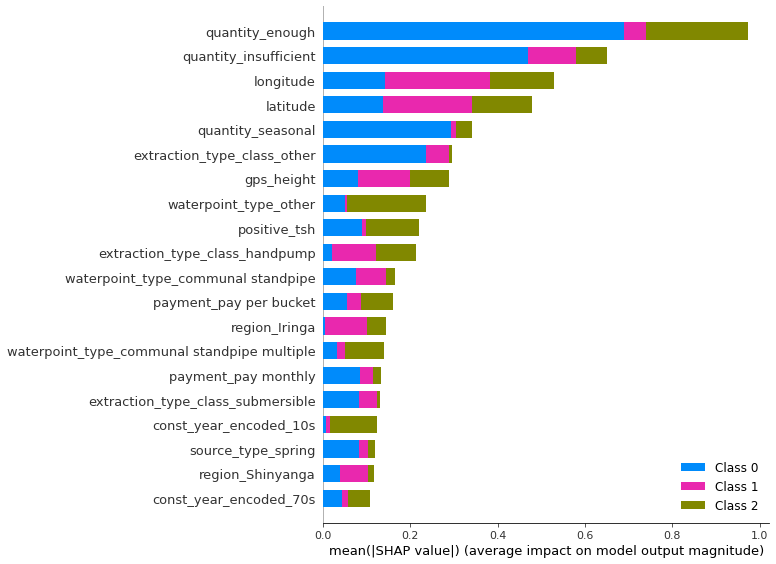

In [55]:
import shap
xgb_model_shap = shap.TreeExplainer(xgb_model_v3).shap_values(X_train_scaled)
shap.summary_plot(xgb_model_shap, X_train_scaled, plot_type='bar')

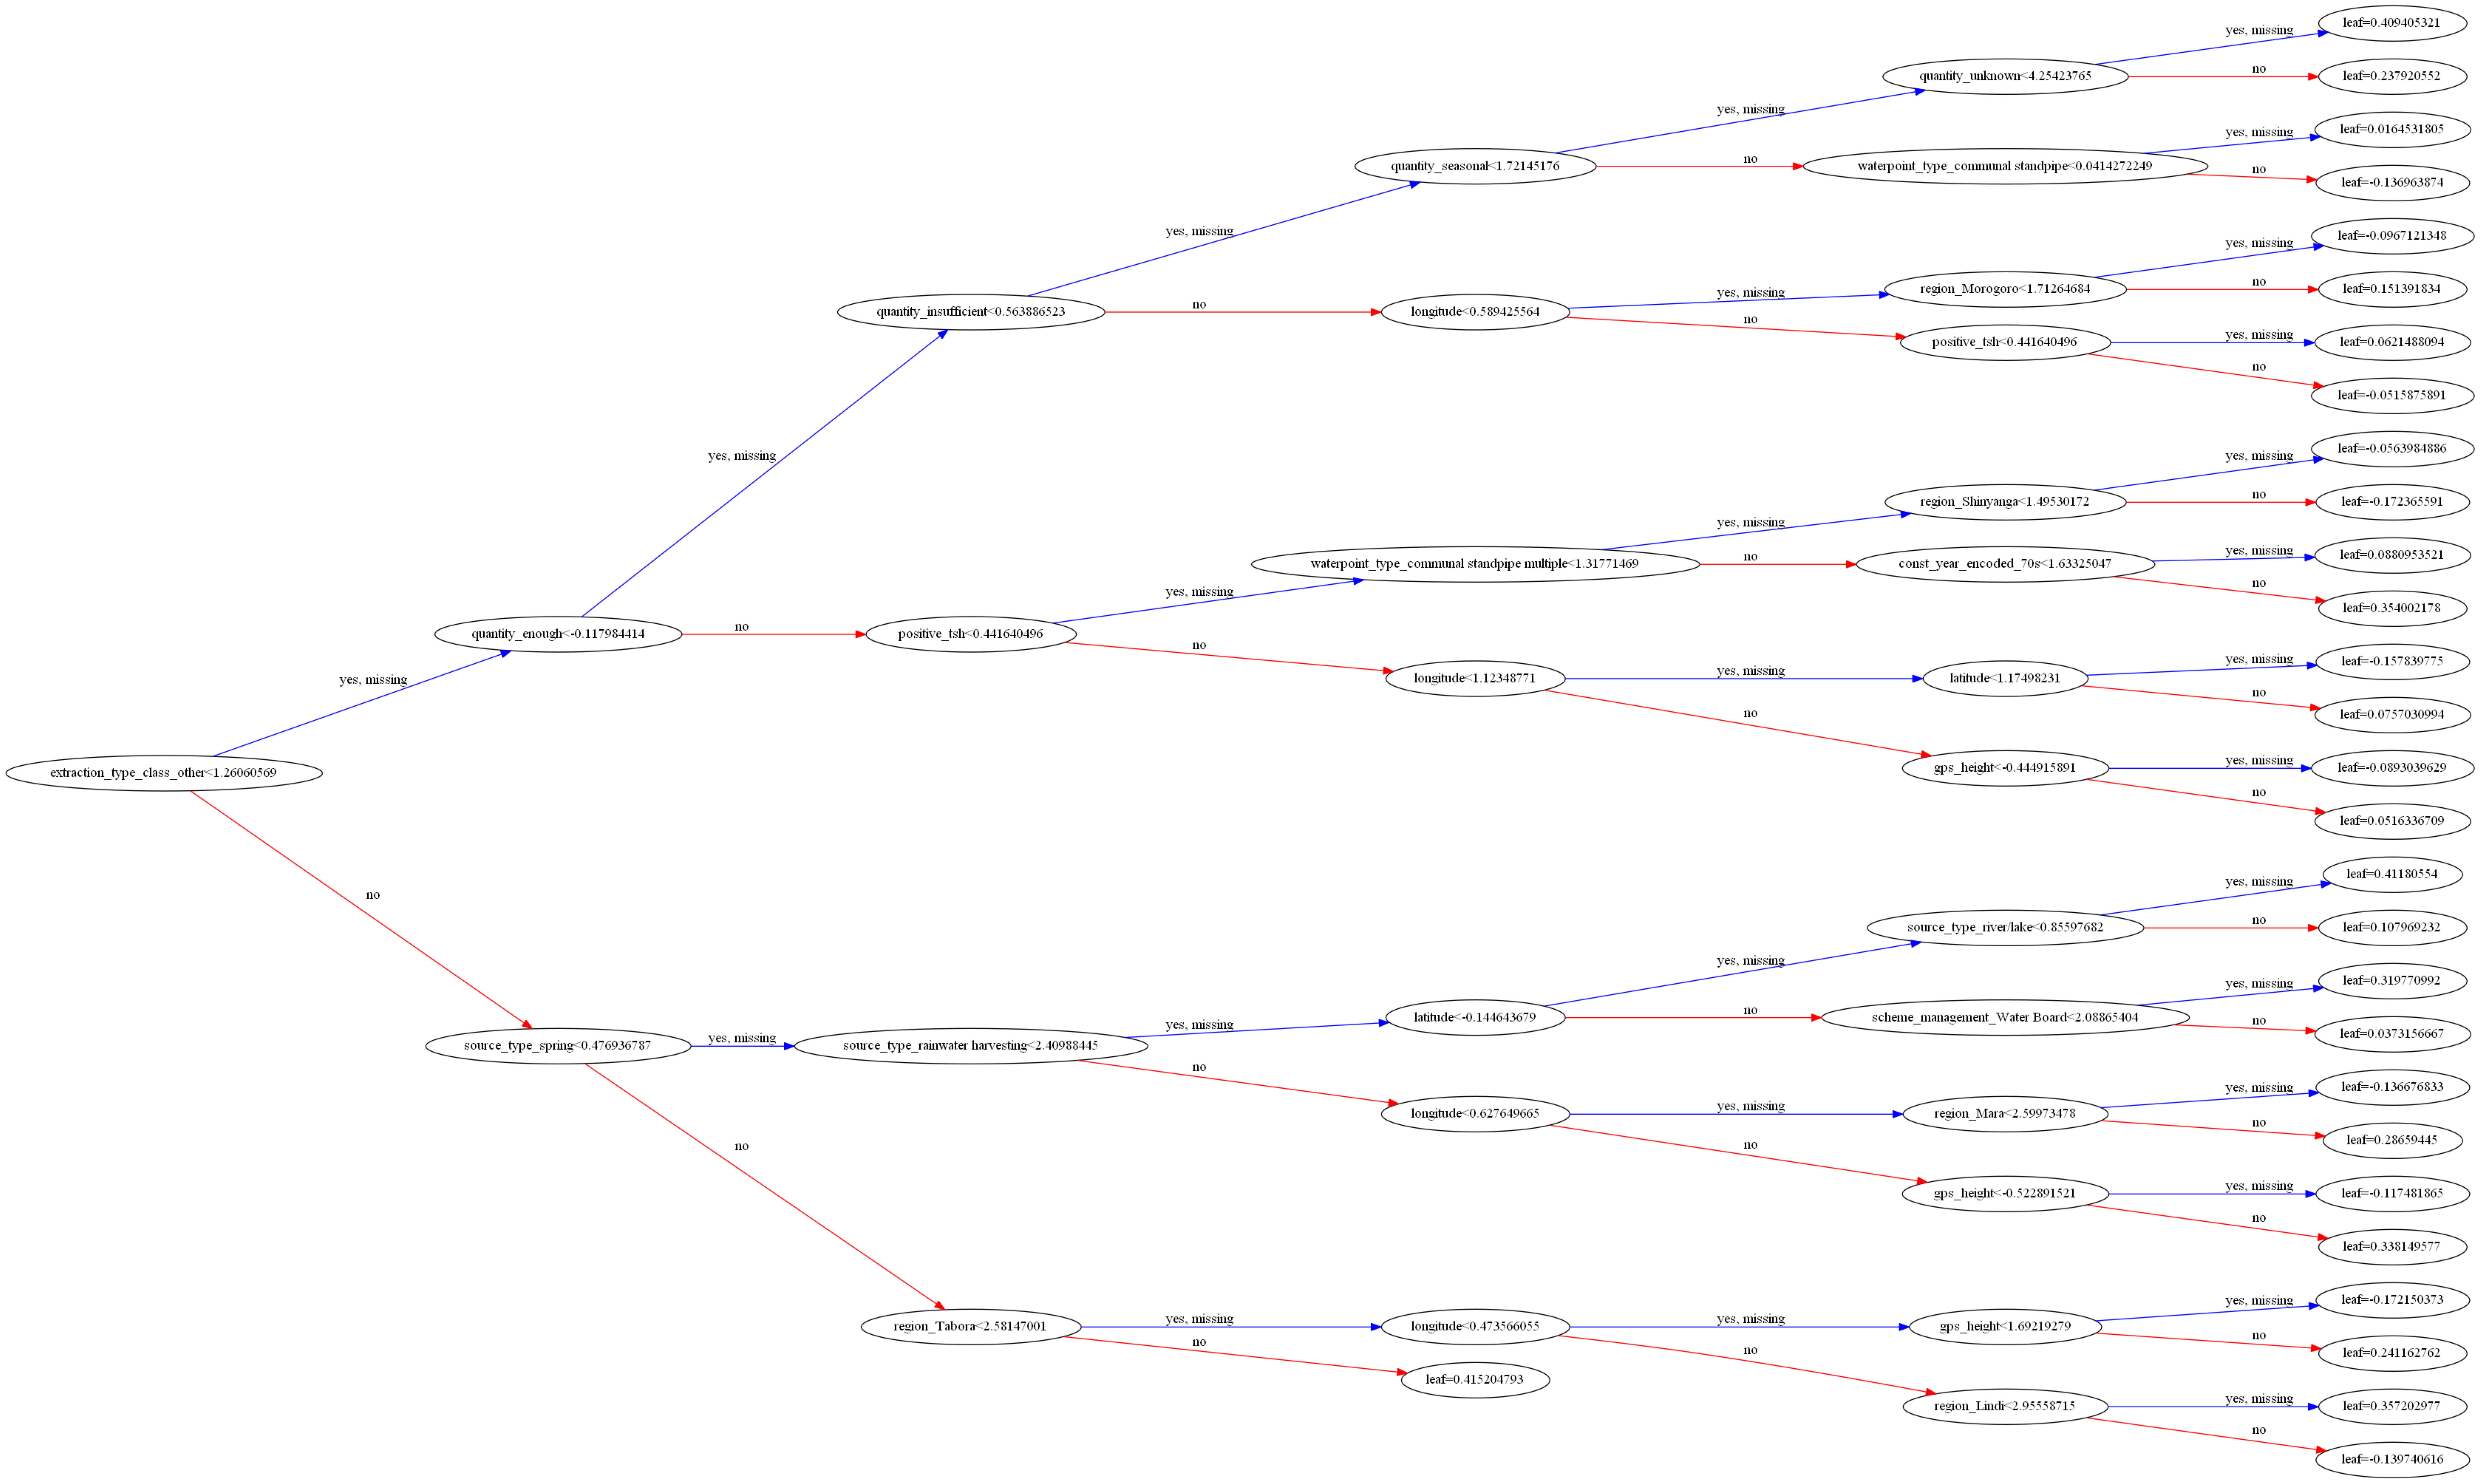

In [56]:
xgboost.plot_tree(xgb_model_v3, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150,100)
plt.savefig('images/tree.png')

In [57]:
# We were experiencing difficulties in reading the tree plot, so we found this
# online. The results did not match, so we are not using it.

# https://stackoverflow.com/questions/37340474/xgb-plot-tree-font-size-python

def plot_tree(xgb_model, filename, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    import xgboost as xgb
    import os
    gvz = xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)
        
# plot_tree(xgb_model_v3, 'images/tree_helper.png', rankdir='LR')

Finally, we need to output the GPS coordinates and predicted status for our testing data so we can map it for display in the presentation

In [58]:
test_map_data = pd.concat([encoded_test_df[['longitude', 'latitude']], xgb_predictions], axis=1)
test_map_data.to_csv('data/test_map_data.csv')